In [1]:
import os

import numpy as np
import scipy as sp
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

from ipywidgets import interact, IntSlider, FloatSlider, fixed
from astropy.modeling.models import Gaussian1D

# import lightkurve as lk

# import seaborn as sns

# import echelle
from astropy.timeseries import LombScargle
from astropy.convolution import convolve, Box1DKernel, Gaussian1DKernel

In [2]:
# Set plotting style 
# sns.set(style="ticks", palette="muted", 
#         rc={"xtick.bottom" : True, "ytick.left" : True})
plt.style.use('../mesaruns/mesa-gyre-tutorial-2022/src/matplotlibrc')

# Convenience Functions

In [3]:
def load_history_file(logs_dir):
    return pd.read_table(os.path.join(logs_dir, 'history.data'), 
                         
        skiprows=5, sep='\s+')

In [4]:
def get_index(logs_dir):
    return pd.read_table(os.path.join(logs_dir, 'profiles.index'), 
        names=['model_number', 'priority', 'profile_number'],
        skiprows=1, sep='\s+')

In [5]:
def get_history(profile_number, DF, index):
    model_number = index[index.profile_number == profile_number].model_number.values[0]
    return DF[DF.model_number == model_number]

In [6]:
def plot_HR(profile_number=-1):
    plt.plot(10**DF['log_Teff'][1:], 
             10**DF['log_L'][1:], 
             lw=3, c='k', label='evolutionary track')
    
    first = 1
    for prof_num in index.profile_number:
        hist = get_history(prof_num,DF,index)
        plt.plot(10**hist['log_Teff'], 10**hist['log_L'], '.',
                 c='r' if prof_num == profile_number else 'b', 
                 label=r'%0.2f Gyr' % (hist.star_age.values[0]/1e9)
                       if prof_num == profile_number else 'profile files' if first else '',
                 ms=20)
        if not prof_num == profile_number:
            first = 0
    
    plt.gca().invert_xaxis()
    plt.xlabel(r'effective temperature $T_{\rm{eff}}/\rm{K}$')
    plt.ylabel(r'luminosity $L/\rm{L}_\odot$')
    plt.xlim(left=5000)
    
    plt.legend()
    plt.title('HR Diagram', size=24)

In [7]:
def load_profile(profile_number, logs_dir):
    prof = pd.read_table(
        os.path.join(logs_dir, 'profile' + str(profile_number) + '.data'), 
        skiprows=5, sep='\s+')
    return prof

In [8]:
def get_profiles(index, logs_dir):
    return [load_profile(profile_number, logs_dir) 
            for profile_number in index.profile_number]

In [9]:
def plot_composition(profile_number):
    prof = profs[profile_number-1]
    x = 10**prof.logR / np.max(10**prof.logR)
    plt.plot(x, prof.x_mass_fraction_H, lw=5, label='hydrogen', c='k')
    plt.plot(x, prof.y_mass_fraction_He, lw=5, label='helium', c='b')
    plt.axhline(ZAMS_X, c='k', ls='--', zorder=-99)
    plt.axhline(ZAMS_Y, c='k', ls='--', zorder=-99)
    plt.axhline(Y_p, c='lightgray', ls='--', zorder=-99)
    plt.xlabel(r'fractional radius $r/R$')
    plt.ylabel(r'mass fraction')
    plt.legend()
    plt.title('Internal Composition', size=24)

In [10]:
def plot_propagation(profile_number):
    hist = get_history(profile_number,DF,index)
    prof = profs[profile_number-1]
    
    x = 10**prof.logR / np.max(10**prof.logR)
    brunt = prof.brunt_N.values/(2*np.pi)*1e6
    lamb  = prof.lamb_S.values*1e6
    plt.plot(x, brunt, lw=3, label='Buoyancy')
    plt.plot(x, lamb, lw=3, label='Lamb')
    
    gmodes = np.minimum(brunt, lamb)
    pmodes = np.maximum(brunt, lamb)
    plt.fill_between(x, 
                     np.zeros(len(gmodes)), 
                     gmodes, 
                     color='blue', alpha=0.1, zorder=-99)
    plt.fill_between(x, 
                     1e99*np.ones(len(pmodes)), 
                     pmodes, 
                     color='orange', alpha=0.1, zorder=-99)
    
    nu_max   = hist.nu_max.values[0]
    Delta_nu = hist.delta_nu.values[0]
    plt.axhline(nu_max, ls='--', c='k', label=r'$\nu_\max$', zorder=100)
    plt.fill_between([0, 1], 
                     nu_max-5*Delta_nu, 
                     nu_max+5*Delta_nu, 
                     color='#aaaaaa', zorder=-98)
    
    plt.semilogy()
    plt.ylim([1, 1e7]) #500*nu_max])
    plt.xlim([0,1])
    plt.ylabel(r'frequency $\nu/\mu\rm{Hz}$')
    plt.xlabel(r'fractional radius $r/R$')
    plt.legend()
    plt.title('Propagation Diagram', size=24)
    plt.show()

In [11]:
def get_frequencies(profile_number, logs_dir):
    path = os.path.join(logs_dir, 'profile' + str(profile_number) + '-freqs.dat')
    return pd.read_table(path, skiprows=5, sep='\s+')

In [12]:
def get_all_frequencies(index, logs_dir):
    return [get_frequencies(profile_number, logs_dir=logs_dir) 
            for profile_number in index.profile_number]

In [13]:
def plot_echelle(profile_number,freq):
    hist = get_history(profile_number,DF,index)
    prof = profs[profile_number-1]
    freq = freq
    
    nu_max   = hist.nu_max.values[0]
    Delta_nu = hist.delta_nu.values[0]
    
    #freq = freqs[1]
    freq = freq[freq['Re(freq)'] < 5/3*nu_max]
    radial = freq[np.logical_and(freq.l == 0, freq.n_p > 10)]
    Dnu = Delta_nu
#     Dnu = np.mean(np.diff(radial['Re(freq)'].values))
    
    colors = ('black', 'red', 'blue', 'purple')
    for ell in np.unique(freq.l.values):
        nus = freq[freq.l == ell]
        plt.plot(nus['Re(freq)'] % Dnu,
                 nus['Re(freq)'], '.', 
                 mfc=colors[ell], mec='white', alpha=0.85,
                 ms=15, mew=1, 
                 label=str(ell))
    
    plt.legend(loc='lower right')
    
    plt.axvline(Dnu, ls='--', c='darkgray', zorder=-99)
    plt.axhline(nu_max, ls='--', c='darkgray', zorder=-99)
    
    plt.ylim([0, nu_max*5/3*1.2])
    plt.xlim([-10, Dnu*1.4])
    
    plt.ylabel(r'frequency $\nu/\mu\rm{Hz}$')
    plt.xlabel(r'$\nu\; \rm{mod}\; \Delta\nu/\mu\rm{Hz}$')
    plt.title('Echelle Diagram', size=24)

# Working Section

When running GYRE through MESA you need a few things

1) instruct MESA to output FGONG files using the control `write_pulse_data_with_profile = .true.` (defaults to FGONG form), `add_atmosphere_to_pulse_data = .true.` and `profile_interval=20` can be useful.   
2) uncomment `delta_nu` and `nu_max` from `history_columns.list`   
3) uncomment `brunt_N` NOT N2 and `lamb_S` from `profile_columns.list`   

Note that `nu_max` in the models is calculated from the scaling relations: `nu_max = nu_max_sun * M/Msun / ((R/Rsun)^2 (Teff/Teff_sun)^0.5)`

In [18]:
# logs_dir = os.path.join('../mesaruns/7M_prems_to_AGB/', 'LOGS')
logs_dir = os.path.join('../mesaruns/highmass_rc_test1/', 'LOGS_4M')

In [19]:
DF = load_history_file(logs_dir)
DF

,model_number,num_zones,star_age,log_dt,star_mass,log_xmstar,log_abs_mdot,mass_conv_core,conv_mx1_top,conv_mx1_bot,...,center_o16,surface_c12,surface_o16,total_mass_h1,total_mass_he4,delta_nu,delta_Pg,nu_max,num_retries,num_iters
0,52,597,5.540337e-01,-1.267335,4.0,33.900566,-99.0,0.000000,1.000000,0.014410,...,0.011231,0.004136,0.011231,2.744000,1.159877,3.341313,0.000000,38.077141,0,2
1,60,597,1.623842e+00,-0.633885,4.0,33.900566,-99.0,0.000000,1.000000,0.014410,...,0.011231,0.004136,0.011231,2.744000,1.159877,3.341390,0.000000,38.078289,0,2
2,70,597,8.861176e+00,0.157927,4.0,33.900566,-99.0,0.000000,1.000000,0.014418,...,0.011231,0.004136,0.011231,2.744000,1.159877,3.341914,0.000000,38.086056,0,2
3,80,597,5.367284e+01,0.949740,4.0,33.900566,-99.0,0.000000,1.000000,0.014470,...,0.011231,0.004136,0.011231,2.744000,1.159877,3.345156,0.000000,38.134131,0,2
4,90,596,3.311349e+02,1.741552,4.0,33.900566,-99.0,0.000000,1.000000,0.014948,...,0.011231,0.004136,0.011231,2.744000,1.159877,3.365171,0.000000,38.431294,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,640,1652,2.017706e+08,5.078880,4.0,33.900566,-99.0,0.257266,1.000000,0.725623,...,0.481484,0.004136,0.011231,2.116916,1.432352,1.789487,360.225975,14.776307,0,10
60,650,1876,2.028306e+08,4.717417,4.0,33.900566,-99.0,0.079732,0.999999,0.348442,...,0.576278,0.004136,0.011231,2.114557,1.425631,0.999585,118.336437,7.040594,0,10
61,660,1798,2.033464e+08,4.916325,4.0,33.900566,-99.0,0.000000,0.999999,0.346816,...,0.576282,0.004136,0.011231,2.114150,1.403459,1.043733,63.258176,7.456628,0,10
62,670,1626,2.044367e+08,4.865637,4.0,33.900566,-99.0,0.000000,0.999996,0.225314,...,0.576282,0.004136,0.011231,2.114148,1.323367,0.521053,42.396127,2.995537,0,10


In [20]:
index = get_index(logs_dir)
index

,model_number,priority,profile_number
0,51,3,1
1,60,1,2
2,70,1,3
3,80,1,4
4,90,1,5
...,...,...,...
59,640,1,60
60,650,1,61
61,660,1,62
62,670,1,63


In [21]:
get_history(53,DF,index)

,model_number,num_zones,star_age,log_dt,star_mass,log_xmstar,log_abs_mdot,mass_conv_core,conv_mx1_top,conv_mx1_bot,...,center_o16,surface_c12,surface_o16,total_mass_h1,total_mass_he4,delta_nu,delta_Pg,nu_max,num_retries,num_iters
52,570,1349,1.848903e+08,5.439564,4.0,33.900566,-99.0,0.247446,1.0,0.883368,...,0.049448,0.004136,0.011231,2.150983,1.621041,2.268492,388.45786,19.735966,0,10


In [22]:
hist = get_history(53,DF,index)
print(10**hist.log_L.values[0],hist.log_L.values[0])
print(10**hist.log_Teff.values[0])
print(10**hist.log_R.values[0])
print(hist.model_number.values[0])
print(hist.nu_max.values[0],hist.delta_nu.values[0])

342.8566925202849 2.5351126312587717
4854.17647493223
26.180525174456122
570
19.73596562591558 2.2684919806521355


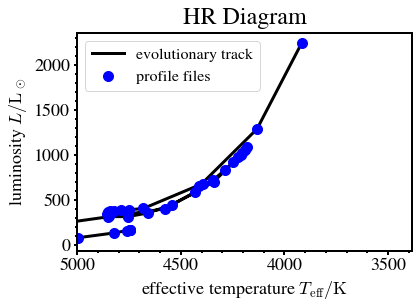

In [23]:
plot_HR()

In [57]:
model4 = [DF['log_Teff'][1:],DF['log_L'][1:],DF['nu_max'][1:]]
# model4

In [58]:
output = pd.DataFrame(data=np.asarray(model4).transpose(),columns=['log_Teff','log_L','nu_max'])
output

,log_Teff,log_L,nu_max
0,3.696216,1.372577,194.547355
1,3.696216,1.372568,194.552424
2,3.696219,1.372507,194.583809
3,3.696236,1.372132,194.778085
4,3.696339,1.369823,195.978956
...,...,...,...
81,3.621199,2.689121,5.127712
82,3.614285,2.765384,4.068725
83,3.609299,2.820073,3.446040
84,3.605321,2.863181,3.021955


In [59]:
# output.to_csv('../datatables/2.5M_track.csv',index=False)

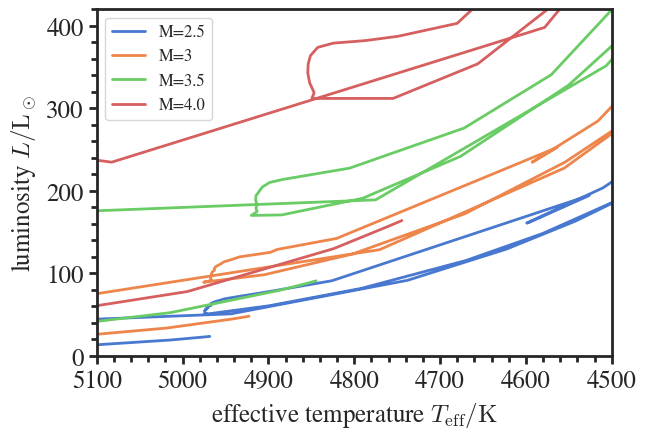

In [51]:
plt.plot(10**model1[0],10**model1[1],label='M=2.5')
plt.plot(10**model2[0],10**model2[1],label='M=3')
plt.plot(10**model3[0],10**model3[1],label='M=3.5')
plt.plot(10**model4[0],10**model4[1],label='M=4.0')
plt.gca().invert_xaxis()
plt.xlabel(r'effective temperature $T_{\rm{eff}}/\rm{K}$')
plt.ylabel(r'luminosity $L/\rm{L}_\odot$')
plt.xlim(left=5500)
plt.xlim(5250,4750)
plt.xlim(5100,4500)
plt.ylim(0,420)
plt.legend(fontsize=12)
plt.show()

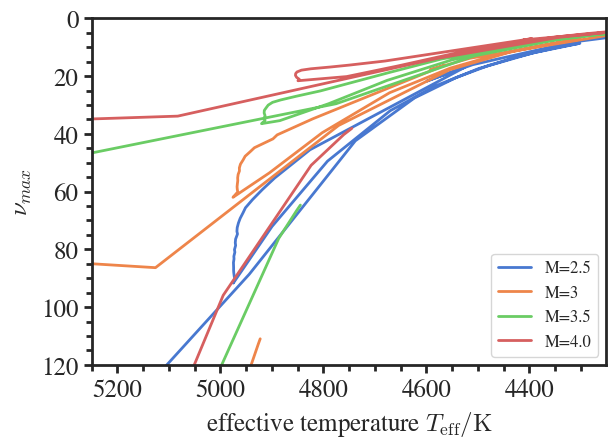

In [52]:
plt.plot(10**model1[0],model1[2],label='M=2.5')
plt.plot(10**model2[0],model2[2],label='M=3')
plt.plot(10**model3[0],model3[2],label='M=3.5')
plt.plot(10**model4[0],model4[2],label='M=4.0')
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel(r'effective temperature $T_{\rm{eff}}/\rm{K}$')
plt.ylabel(r'$\nu_{max}$')
# plt.xlim(left=5500)
plt.xlim(5250,4250)
plt.ylim(120,0)
plt.legend(fontsize=12)
plt.show()

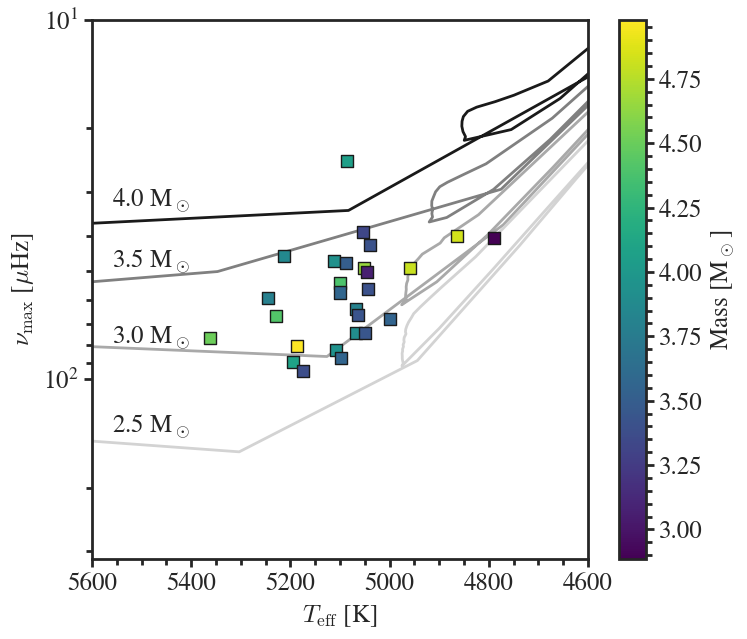

In [117]:
plt.figure(figsize=(8,7))
# plt.plot(10**model1[0][10:],model1[2][10:],label='M=2.5',linestyle='--')#,Z=0.024,Y=0.29')
# # plt.plot(10**model1[0][DF['center_he4']<0.9][15:],model1[2][DF['center_he4']<0.9][15:],label='M=2.5',linestyle='--')#,Z=0.024,Y=0.29')
# plt.plot(10**model2[0][10:],model2[2][10:],label='M=3',linestyle='--')#,Z=0.024,Y=0.29')
# plt.plot(10**model3[0][10:],model3[2][10:],label='M=3.5',linestyle='--')#,Z=0.024,Y=0.29')
# plt.plot(10**model4[0][10:],model4[2][10:],label='M=4.0',linestyle='--')#,Z=0.024,Y=0.29')

plt.plot(10**model4[0][10:],model4[2][10:],label=r'4.0 M$_\odot$',linestyle='-',c='k')#,Z=0.024,Y=0.29')
plt.plot(10**model3[0][10:],model3[2][10:],label=r'3.5 M$_\odot$',linestyle='-',c='grey')#,Z=0.024,Y=0.29')
plt.plot(10**model2[0][10:],model2[2][10:],label=r'3.0 M$_\odot$',linestyle='-',c='darkgrey')#,Z=0.024,Y=0.29')
plt.plot(10**model1[0][10:],model1[2][10:],label=r'2.5 M$_\odot$',linestyle='-',c='lightgrey')#,Z=0.024,Y=0.29')

plt.annotate(r'4.0 M$_\odot$',xy=(5560,10**(1.52)),annotation_clip=False)
plt.annotate(r'3.5 M$_\odot$',xy=(5560,10**(1.69)),annotation_clip=False)
plt.annotate(r'3.0 M$_\odot$',xy=(5560,10**(1.9)),annotation_clip=False)
plt.annotate(r'2.5 M$_\odot$',xy=(5560,10**(2.15)),annotation_clip=False)

# plt.annotate(adjusted_masses['KIC'][adjusted_masses['a_corr_mass']!=np.nan],
#              xy=(highmass_rc['ClcorM'],adjusted_masses['a_corr_mass']),
#              annotation_clip=False)

# plt.scatter(jie_cheb['Teff'][jie_cheb['ClcorM']>2.5],jie_cheb['numax'][jie_cheb['ClcorM']>2.5],color='k',s=5)
# plt.scatter(new_cat['Teff'],new_cat['numax'],c=adjusted_masses['corr_mass'],
#            cmap=plt.cm.viridis,s=30,alpha=1,edgecolor='k',linewidth=0.5,marker='s')
# plt.scatter(jie_rgb['Teff'][jie_rgb['RGBcorM']>4],
#             jie_rgb['numax'][jie_rgb['RGBcorM']>4],
#             c=jie_rgb['RGBcorM'][jie_rgb['RGBcorM']>4],
#             cmap=plt.cm.viridis,s=30,alpha=1,edgecolor='k',linewidth=0.5)
# plt.scatter(jie_cheb['Teff'][jie_cheb['ClcorM']>4],
#             jie_cheb['numax'][jie_cheb['ClcorM']>4],
#             c=jie_cheb['ClcorM'][jie_cheb['ClcorM']>4],
#             cmap=plt.cm.viridis,s=30,alpha=1,edgecolor='k',linewidth=0.5)
# plt.scatter(new_cat['Teff'],new_cat['numax'],color='r')
plt.scatter(keck_targets['teff'],keck_targets['numax'],
            zorder=3,marker='s',s=75,alpha=1,edgecolor='k',linewidth=1,
            c=keck_targets['mass'],cmap=plt.cm.viridis)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.yscale('log')
plt.xlabel(r'$T_{\rm{eff}}$ [K]')
plt.ylabel(r'$\nu_{\rm max}$ [$\mu$Hz]')
# plt.xlim(left=5500)
plt.xlim(7250,3500)
plt.xlim(6000,4500)
plt.xlim(5600,4600)
# plt.ylim(10**(4),10**(0.3))
plt.ylim(10**(2.5),10**(1))
# plt.ylim(120,0)
plt.colorbar(label=r'Mass [M$_\odot$]')
# lim = np.max([np.abs(np.min(teff_diff)),np.max(teff_diff)])
# plt.clim(3,5.3)
# plt.legend(fontsize=12,loc='upper left')
plt.savefig('../highmass_tracks_prop',dpi=300,bbox_inches='tight')
plt.show()

In [55]:
new_cat = pd.read_csv('../highmass_rc_newvals.csv')
new_cat

,KIC,numax,new_numax,smooth_numax,Delnu,o_Teff,o_log(g),o_[Fe/H],g_Teff,g_Teff_e,...,a_log(g),a_log(g)_e,a_[Fe/H],a_[Fe/H]_e,L_Teff,L_Teff_e,L_log(g),L_log(g)_e,L_[Fe/H],L_[Fe/H]_e
0,3347458,39.99,41.04,31.99,3.360,5000,2.519,0.18,NaN,NaN,...,2.525,0.039,0.1650,0.0066,NaN,NaN,NaN,NaN,NaN,NaN
1,8378545,48.82,50.42,39.06,3.952,5058,2.608,0.22,NaN,NaN,...,3.142,0.059,0.1570,0.0067,5009.00,32.00,2.761,0.053,0.323,0.030
2,5978324,49.10,49.96,47.12,4.024,5051,2.610,-0.07,NaN,NaN,...,2.701,0.050,-0.0980,0.0081,NaN,NaN,NaN,NaN,NaN,NaN
3,10068490,66.42,62.88,53.14,5.206,5189,2.747,-0.14,5740.95,4.38,...,2.769,0.062,-0.2010,0.0101,5254.75,37.05,2.699,0.061,-0.216,0.035
4,4756133,80.81,81.31,65.16,5.865,5152,2.831,0.11,NaN,NaN,...,3.014,0.056,0.0910,0.0081,NaN,NaN,NaN,NaN,NaN,NaN
5,7175316,43.30,43.36,38.43,3.736,5007,2.554,-0.04,4923.40,4.75,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7024018,89.54,86.30,73.75,6.598,5235,2.879,-0.17,5040.59,8.93,...,3.101,0.057,0.0700,0.0082,5206.64,19.86,2.870,0.031,0.123,0.017
7,6547176,46.76,44.00,40.78,4.044,5195,2.595,0.02,6687.24,73.41,...,2.609,0.053,-0.0030,0.0081,NaN,NaN,NaN,NaN,NaN,NaN
8,8621290,68.01,67.38,60.22,5.403,5253,2.760,0.15,4927.95,6.09,...,2.771,0.046,0.1350,0.0071,NaN,NaN,NaN,NaN,NaN,NaN
9,10384595,47.00,NaN,43.25,4.710,5213,2.662,-0.10,NaN,NaN,...,2.763,0.044,-0.1030,0.0077,4864.00,94.00,2.581,0.154,-0.194,0.091


In [54]:
adjusted_masses = pd.read_csv('../adjusted_masses.csv')
adjusted_masses

,KIC,a_fdnu,a_uncorr_mass,a_corr_mass,a_corr_mass_e,a_gfdnu,a_gcorr_mass,g_fdnu,g_uncorr_mass,g_corr_mass,...,gs_corr_mass,gs_corr_mass_e,gs_gfdnu,gs_gcorr_mass,L_fdnu,L_uncorr_mass,L_corr_mass,L_corr_mass_e,L_gfdnu,L_gcorr_mass
0,3347458,1.025361,4.375684,4.836747,0.664408,1.025361,4.836747,NaN,NaN,NaN,...,4.333152,0.584803,1.011285,4.333152,NaN,NaN,NaN,NaN,NaN,NaN
1,8378545,1.028940,4.283602,4.801420,1.205646,1.028936,4.801350,NaN,NaN,NaN,...,4.400252,1.099319,1.017768,4.400252,1.036133,4.348551,5.011956,1.252503,1.036133,5.011955
2,5978324,1.027984,4.167456,4.653887,0.281489,1.027984,4.653886,NaN,NaN,NaN,...,4.999557,0.272940,1.037613,4.999553,NaN,NaN,NaN,NaN,NaN,NaN
3,10068490,1.032453,3.877714,4.406122,1.135618,1.032453,4.406122,1.019323,4.462190,4.817202,...,4.617819,1.186077,1.037096,4.617833,1.034189,3.907513,4.469930,1.145589,1.034189,4.469931
4,4756133,1.038306,4.283161,4.978123,0.444309,1.038305,4.978113,NaN,NaN,NaN,...,4.367700,0.371971,1.020443,4.367705,NaN,NaN,NaN,NaN,NaN,NaN
5,7175316,NaN,NaN,NaN,NaN,NaN,NaN,1.015040,3.701914,3.929696,...,3.557377,0.723003,1.002783,3.557377,NaN,NaN,NaN,NaN,NaN,NaN
6,7024018,1.028937,3.646258,4.086977,0.479930,1.028935,4.086945,1.014328,3.485913,3.690030,...,3.929638,0.450878,1.025362,3.929634,1.030162,3.659576,4.121479,0.471178,1.030162,4.121479
7,6547176,1.022839,3.593003,3.932656,0.474843,1.022839,3.932656,0.864731,5.375783,3.005838,...,4.522367,0.550791,1.025245,4.522367,NaN,NaN,NaN,NaN,NaN,NaN
8,8621290,1.014382,3.355023,3.552236,0.365209,1.014382,3.552236,1.007818,3.283752,3.387649,...,3.195241,0.317657,1.000232,3.195242,NaN,NaN,NaN,NaN,NaN,NaN
9,10384595,0.987834,1.880759,1.790887,0.069126,0.987833,1.790886,NaN,NaN,NaN,...,1.661734,0.050680,0.979428,1.661734,0.981683,1.840317,1.709138,0.068332,0.981683,1.709138


In [69]:
keck_targets = pd.DataFrame(index=range(len(adjusted_masses)-3),columns=['KIC','mass','teff','numax'])
xx = 0
for i in range(0,len(adjusted_masses)):
    if adjusted_masses['KIC'][i] not in [3747623,10384595,2579142]:
        keck_targets['KIC'][xx] = adjusted_masses['KIC'][i]
        keck_targets['numax'][xx] = new_cat['numax'][i]
        if ~np.isnan(adjusted_masses['a_corr_mass'][i]):
            keck_targets['mass'][xx] = adjusted_masses['a_corr_mass'][i]
            keck_targets['teff'][xx] = new_cat['a_Teff'][i]
        elif ~np.isnan(adjusted_masses['L_corr_mass'][i]):
            keck_targets['mass'][xx] = adjusted_masses['L_corr_mass'][i]
            keck_targets['teff'][xx] = new_cat['L_Teff'][i]
        xx = xx + 1
        
        
keck_targets

,KIC,mass,teff,numax
0,3347458,4.836747,4863.0,39.99
1,8378545,4.80142,4959.0,48.82
2,5978324,4.653887,5051.0,49.1
3,10068490,4.406122,5228.0,66.42
4,4756133,4.978123,5186.0,80.81
5,7175316,NaN,NaN,43.3
6,7024018,4.086977,5194.0,89.54
7,6547176,3.932656,5112.0,46.76
8,8621290,3.552236,4999.0,68.01
9,6599955,4.5095,5361.0,76.5


In [52]:
jie_cat = pd.read_csv('../yu_catalog.tsv',sep='\t',nrows=1000)
jie_cat

,KIC,Kpmag,QLen,DLen,numax,Delnu,A,Width,Gran,Teff,...,NoCorR,RGBcorM,RGBcorR,ClcorM,ClcorR,Phase,M17,Simbad,_RA,_DE
0,3347458,10.30,17,1235.8,39.99,3.360,39.7,17.4,950.1,5000,...,19.46,5.15,20.68,5.24,20.87,2,M17,Simbad,292.77283,38.432480
1,8378545,11.78,17,1235.5,48.82,3.977,23,22.9,731.4,5058,...,17.06,4.91,18.23,4.90,18.21,2,M17,Simbad,296.26709,44.371861
2,5978324,10.96,18,1318.1,49.10,4.074,23.5,17.6,362.2,5051,...,16.34,4.41,17.24,4.70,17.78,2,M17,Simbad,296.65195,41.222080
3,10068490,12.26,18,1317.7,66.42,5.206,13.7,19.1,238.2,5189,...,13.72,4.38,14.67,4.61,15.04,2,M17,Simbad,289.05295,47.040981
4,4756133,10.58,14,974.9,80.81,5.994,19.9,31.3,167.4,5152,...,12.55,4.45,13.43,4.51,13.51,2,M17,Simbad,294.38312,39.844940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,4940916,11.01,15,1057.3,74.24,6.525,28.6,24.5,611.3,5035,...,9.62,2.04,9.54,2.14,9.76,2,M17,Simbad,296.13626,40.066319
996,5716459,9.90,2,41.9,63.23,5.704,98.6,15.3,1780.1,4868,...,10.54,1.97,10.24,2.14,10.66,2,M17,Simbad,295.01682,40.950905
997,6150124,7.25,17,1308.7,42.90,4.331,45.2,18.3,520.2,5047,...,12.63,2.04,12.54,2.14,12.83,2,M17,Simbad,298.64722,41.464386
998,6635875,12.78,8,557.6,54.60,5.077,61.8,20.4,828.8,4801,...,11.41,1.98,11.09,2.14,11.53,2,M17,Simbad,298.99741,42.021580


In [53]:
jie_rgb = jie_cat[jie_cat['Phase']==1]
jie_rgb = jie_rgb.sort_values(by=['ClcorM'],ascending=True)
jie_rgb

,KIC,Kpmag,QLen,DLen,numax,Delnu,A,Width,Gran,Teff,...,NoCorR,RGBcorM,RGBcorR,ClcorM,ClcorR,Phase,M17,Simbad,_RA,_DE
993,3941607,12.17,18,1318.1,84.26,7.233,30.2,26.5,262.2,5139,...,8.97,2.08,9.00,2.14,9.12,1,M17,Simbad,287.55637,39.074341
968,4567173,12.79,14,1031.4,92.32,7.760,39.2,29.9,225.6,5182,...,8.58,2.14,8.69,2.15,8.71,1,M17,Simbad,293.25345,39.663750
970,5087808,13.18,18,1317.8,160.71,11.715,22.2,72.2,32.3,5128,...,6.52,2.09,6.53,2.15,6.62,1,M17,Simbad,288.18518,40.281010
971,5112880,12.29,14,1047.8,25.73,2.800,100.7,10.8,3469.5,4497,...,17.10,1.97,16.36,2.15,17.11,1,M17,Simbad,295.36282,40.207870
989,11204531,10.74,15,1055.7,41.86,4.227,64.4,16.2,1098.5,5002,...,12.88,2.00,12.59,2.15,13.07,1,M17,Simbad,297.86273,48.802841
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,8225926,11.51,4,206.4,29.32,2.932,96.6,11.6,3217.4,4856,...,18.47,2.97,18.47,3.05,18.73,1,M17,Simbad,289.14435,44.157452
66,7901207,11.37,18,1318.0,85.17,6.488,14.4,31.5,309.6,4950,...,11.06,3.35,11.45,3.29,11.35,1,M17,Simbad,295.19717,43.669071
61,4273491,11.62,15,1057.3,71.55,5.694,25.6,22.3,347.5,4963,...,12.08,3.24,12.29,3.31,12.42,1,M17,Simbad,294.28055,39.373791
20,2579142,11.36,8,552.9,5.41,0.747,565,2.2,370877.1,4124,...,48.36,3.49,48.61,3.87,51.19,1,M17,Simbad,292.15579,37.848572


In [54]:
jie_cheb = jie_cat[jie_cat['Phase']==2]
jie_cheb = jie_cheb.sort_values(by=['ClcorM'],ascending=True)
jie_cheb

,KIC,Kpmag,QLen,DLen,numax,Delnu,A,Width,Gran,Teff,...,NoCorR,RGBcorM,RGBcorR,ClcorM,ClcorR,Phase,M17,Simbad,_RA,_DE
999,6877290,12.85,18,1317.8,88.09,7.397,43.8,32.3,209.5,5013,...,8.86,2.07,8.83,2.14,8.97,2,M17,Simbad,295.67844,42.347210
991,2983341,14.53,4,271.0,57.58,5.539,82,17.3,561.5,5333,...,10.65,2.12,10.88,2.14,10.93,2,M17,Simbad,289.92307,38.149769
992,3102465,13.50,9,715.0,58.05,5.369,66.9,18.1,746.5,4950,...,11.01,2.10,10.98,2.14,11.09,2,M17,Simbad,287.50839,38.292229
994,4474383,9.87,15,1057.2,49.10,4.709,62.4,18.8,996.1,4856,...,11.99,2.00,11.71,2.14,12.13,2,M17,Simbad,294.28293,39.570080
998,6635875,12.78,8,557.6,54.60,5.077,61.8,20.4,828.8,4801,...,11.41,1.98,11.09,2.14,11.53,2,M17,Simbad,298.99741,42.021580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,4756133,10.58,14,974.9,80.81,5.994,19.9,31.3,167.4,5152,...,12.55,4.45,13.43,4.51,13.51,2,M17,Simbad,294.38312,39.844940
3,10068490,12.26,18,1317.7,66.42,5.206,13.7,19.1,238.2,5189,...,13.72,4.38,14.67,4.61,15.04,2,M17,Simbad,289.05295,47.040981
2,5978324,10.96,18,1318.1,49.10,4.074,23.5,17.6,362.2,5051,...,16.34,4.41,17.24,4.70,17.78,2,M17,Simbad,296.65195,41.222080
1,8378545,11.78,17,1235.5,48.82,3.977,23,22.9,731.4,5058,...,17.06,4.91,18.23,4.90,18.21,2,M17,Simbad,296.26709,44.371861


In [105]:
load_profile(53,logs_dir)

,zone,mass,logR,logT,logRho,logP,x_mass_fraction_H,y_mass_fraction_He,z_mass_fraction_metals,pp,cno,tri_alfa,brunt_N,lamb_S
0,1,2.650000e+00,1.024397,3.697158,-7.574747,3.919978,0.686,0.2900,0.0240,3.750321e-27,0.0,0.000000,0.000605,0.000001
1,2,2.650000e+00,1.024397,3.697161,-7.574723,3.920006,0.686,0.2900,0.0240,3.750529e-27,0.0,0.000000,0.000605,0.000001
2,3,2.650000e+00,1.024397,3.697165,-7.574697,3.920036,0.686,0.2900,0.0240,3.750756e-27,0.0,0.000000,0.000605,0.000001
3,4,2.650000e+00,1.024397,3.697169,-7.574665,3.920073,0.686,0.2900,0.0240,3.751035e-27,0.0,0.000000,0.000605,0.000001
4,5,2.650000e+00,1.024397,3.697175,-7.574629,3.920114,0.686,0.2900,0.0240,3.751349e-27,0.0,0.000000,0.000605,0.000001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1363,1364,3.312893e-06,-3.252176,8.064377,4.425842,20.320288,0.000,0.7927,0.2073,0.000000e+00,0.0,4780.833883,0.000000,4.121544
1364,1365,1.656447e-06,-3.352534,8.064415,4.425902,20.320386,0.000,0.7927,0.2073,0.000000e+00,0.0,4796.736028,0.000000,5.193265
1365,1366,8.282233e-07,-3.452886,8.064439,4.425940,20.320448,0.000,0.7927,0.2073,0.000000e+00,0.0,4806.779234,0.000000,6.543455
1366,1367,4.141116e-07,-3.553235,8.064454,4.425964,20.320487,0.000,0.7927,0.2073,0.000000e+00,0.0,4813.116183,0.000000,8.244515


In [106]:
profs = get_profiles(index,logs_dir)

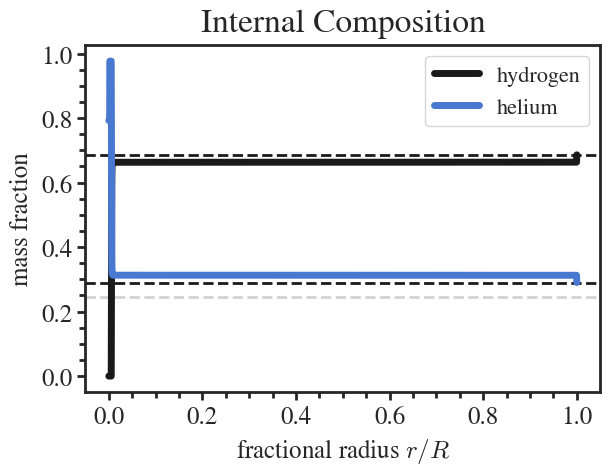

In [107]:
ZAMS_X = profs[0].x_mass_fraction_H.values[0]
ZAMS_Y = profs[0].y_mass_fraction_He.values[0]
Y_p = 0.2463

plot_composition(53)

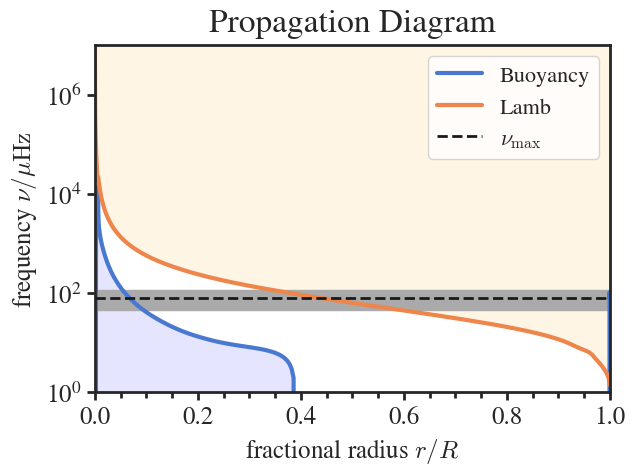

In [108]:
plot_propagation(53)

So that's good, MESA is showing that we are indeed replicating the g-mode core and p-mode envelope situation that's typical of red giants. nu_max is in a good place too

All of this was native to MESA itself, but now we can do some frequency calculation using GYRE. GYRE uses post-processing, so you'll need to put an inlist into the LOGS directory and run it there. 

Make sure to create the folder before running gyre again

`$GYRE_DIR/bin/gyre gyre.in`

In [109]:
freq = get_frequencies(53,logs_dir)
freq

,l,n_pg,n_p,n_g,Re(freq),Im(freq),E_norm,E_p,E_g
0,0,9,9,0,64.458103,0.0,1.422598e-06,0.966954,0.000000
1,0,10,10,0,70.613075,0.0,1.172641e-06,0.962146,0.000000
2,0,11,11,0,77.072989,0.0,1.143240e-06,0.963089,0.000000
3,0,12,12,0,83.650457,0.0,1.041146e-06,0.960504,0.000000
4,0,13,13,0,90.152581,0.0,9.464752e-07,0.956953,0.000000
...,...,...,...,...,...,...,...,...,...
101,2,-72,13,85,95.960021,0.0,1.084396e-06,0.812863,0.134049
102,2,-71,13,84,96.322073,0.0,9.367818e-06,0.093820,0.895964
103,2,-70,13,83,97.424435,0.0,1.311899e-04,0.006730,0.988140
104,2,-69,13,82,98.587431,0.0,2.874389e-04,0.003133,0.991855


In [74]:
# def plot_echelle(profile_number,freq):
#     hist = get_history(profile_number,DF,index)
#     prof = profs[profile_number-1]
#     freq = freq
    
#     nu_max   = hist.nu_max.values[0]
#     Delta_nu = hist.delta_nu.values[0]
    
#     #freq = freqs[1]
# #     freq = freq[freq['Re(freq)'] < 3*nu_max]
#     freq = freq[freq['Re(freq)'] < 5/3*nu_max]
#     print(5/3*nu_max)
# #     print(freq)
#     radial = freq[np.logical_and(freq.l == 0, freq.n_p > 2)]
# #     print(radial)
#     Dnu = Delta_nu
#     print(Dnu)
#     Dnu = np.mean(np.diff(radial['Re(freq)'].values))
#     print(Dnu)
    
#     colors = ('black', 'red', 'blue', 'purple')
#     for ell in np.unique(freq.l.values):
#         nus = freq[freq.l == ell]
#         plt.scatter(nus['Re(freq)'] % Dnu,
#                  nus['Re(freq)'], marker='.', 
#                 facecolor=colors[ell], edgecolor='k',linewidth=0.5,
#                     alpha=1, s=nus['E_p']*150, 
#                  label=str(ell))
# #         plt.plot(nus['Re(freq)'] % Dnu,
# #                  nus['Re(freq)'], '.', 
# #                  mfc=colors[ell], mec='white', alpha=0.85,
# #                  mew=1, markersize=nus['E_p'], 
# #                  label=str(ell))
    
#     plt.legend(loc='lower right')
    
#     plt.axvline(Dnu, ls='--', c='darkgray', zorder=-99)
#     plt.axhline(nu_max, ls='--', c='darkgray', zorder=-99)
    
#     plt.ylim([0, nu_max*5/3*1.2])
#     plt.xlim([0, Dnu*1.2])
    
#     plt.ylabel(r'frequency $\nu/\mu\rm{Hz}$')
#     plt.xlabel(r'$\nu\; \rm{mod}\; \Delta\nu/\mu\rm{Hz}$')
#     plt.title('Echelle Diagram', size=24)
#     plt.show()

In [176]:
def plot_echelle(profile_number,freq,Dnu=0):
    hist = get_history(profile_number,DF,index)
    prof = profs[profile_number-1]
    freq = freq
    
    nu_max   = hist.nu_max.values[0]
    Delta_nu = hist.delta_nu.values[0]
    print(nu_max,Delta_nu)
    
#     #freq = freqs[1]
# #     freq = freq[freq['Re(freq)'] < 3*nu_max]
# #     freq = freq[freq['Re(freq)'] < 5/3*nu_max]
# #     print(5/3*nu_max)
# #     print(freq)
#     radial = freq[np.logical_and(freq.l == 0, freq.n_p > 2)]
# #     print(radial)
#     plt.scatter(radial['n_p'],radial['Re(freq)'])
#     n_for_numax = radial['n_p'][np.argmin(np.abs(radial['Re(freq)']-nu_max))]
#     n_for_fwhm_left = radial['n_p'][np.argmin(np.abs(radial['Re(freq)']-0.8*nu_max))]
#     n_for_fwhm_right = radial['n_p'][np.argmin(np.abs(radial['Re(freq)']-1.2*nu_max))]
#     n_fwhm = n_for_fwhm_right - n_for_fwhm_left
#     print(n_for_numax,n_for_fwhm_left,n_for_fwhm_right,n_fwhm)
#     gaussian_model = Gaussian1D(mean=n_for_numax,stddev=(n_fwhm)/(2*np.sqrt(2*np.log(2))))
# #     dnu_fitting = np.polyfit(radial['n_p'],radial['Re(freq)'], 1, 
# #                              w=gaussian_model(radial['n_p']))
# #     print(dnu_fitting)
# #     plt.plot(radial['n_p'],radial['n_p']*dnu_fitting[0]+dnu_fitting[1])
# #     plt.plot(radial['n_p'],gaussian_model(radial['n_p'])*radial['Re(freq)'][0],marker='.')
#     plt.xlabel('n')
#     plt.ylabel('frequency')
#     plt.show()
    
#     print(radial)
    if Dnu ==0:
        Dnu = Delta_nu
#     print(Dnu)
#     Dnu = np.mean(np.diff(radial['Re(freq)'].values))
#     print(Dnu)
#     Dnu = dnu_fitting[0]
#     print(Dnu)
    
    colors = ('black', 'red', 'blue', 'purple')
    for ell in np.unique(freq.l.values):
        nus = freq[freq.l == ell]
        plt.scatter(nus['Re(freq)'] % Dnu,
                 nus['Re(freq)'], marker='.', 
                facecolor=colors[ell], edgecolor='k',linewidth=0.5,
                    alpha=1, s=np.sqrt(nus['E_p'])*150, 
                 label=str(ell))
#         plt.plot(nus['Re(freq)'] % Dnu,
#                  nus['Re(freq)'], '.', 
#                  mfc=colors[ell], mec='white', alpha=0.85,
#                  mew=1, markersize=nus['E_p'], 
#                  label=str(ell))
    
    plt.legend(loc='lower right')
    
    plt.axvline(Dnu, ls='--', c='darkgray', zorder=-99)
    plt.axhline(nu_max, ls='--', c='darkgray', zorder=-99)
    
#     plt.ylim([0, nu_max*5/3*1.2])
    plt.xlim([0, Dnu*1.2])
    
    plt.ylabel(r'frequency $\nu/\mu\rm{Hz}$')
    plt.xlabel(r'$\nu\; \rm{mod}\; \Delta\nu/\mu\rm{Hz}$')
    plt.title('Echelle Diagram', size=24)
    plt.show()

In [177]:
interact(plot_echelle,profile_number=fixed(53),freq=fixed(freq),
         Dnu=FloatSlider(min=6,max=8,step=0.01))

# plot_echelle(50,freq)

interactive(children=(FloatSlider(value=6.0, description='Dnu', max=8.0, min=6.0, step=0.01), Output()), _dom_…

<function __main__.plot_echelle(profile_number, freq, Dnu=0)>

In [153]:
# plt.scatter(freq['Re(freq)'][freq.l == 1],freq['E_p'][freq.l == 1])
# plt.xlabel('frequency')
# plt.ylabel('E_p')
# plt.show()

In [154]:
# plt.scatter(freq['Re(freq)'][freq.l == 1],freq['E_g'][freq.l == 1])
# plt.xlabel('frequency')
# plt.ylabel('E_g')
# plt.show()

In [155]:
# plt.scatter(freq['Re(freq)'][freq.l == 1],freq['E_norm'][freq.l == 1])
# plt.xlabel('frequency')
# plt.ylabel('E_norm')
# plt.show()

In [37]:
def plot_observed_echelle(profile_number,freq,frequencies,power,dnu,fmin,fmax,smooth_filter_width):
    hist = get_history(profile_number,DF,index)
    prof = profs[profile_number-1]
    freq = freq
    
    nu_max   = hist.nu_max.values[0]
#     print(nu_max)
    Delta_nu = hist.delta_nu.values[0]
    
    #freq = freqs[1]
#     freq = freq[freq['Re(freq)'] < 3*nu_max]
#     freq = freq[freq['Re(freq)'] < 5/3*nu_max]
#     print(5/3*nu_max)
#     print(freq)
    radial = freq[np.logical_and(freq.l == 0, freq.n_p > 2)]
#     print(radial)
#     ax.scatter(radial['n_p'],radial['Re(freq)'])
#     n_for_numax = radial['n_p'][np.argmin(np.abs(radial['Re(freq)']-nu_max))]
#     n_for_fwhm_left = radial['n_p'][np.argmin(np.abs(radial['Re(freq)']-0.8*nu_max))]
#     n_for_fwhm_right = radial['n_p'][np.argmin(np.abs(radial['Re(freq)']-1.2*nu_max))]
#     n_fwhm = n_for_fwhm_right - n_for_fwhm_left
#     print(n_for_numax,n_for_fwhm_left,n_for_fwhm_right,n_fwhm)
#     gaussian_model = Gaussian1D(mean=n_for_numax,stddev=(n_fwhm)/(2*np.sqrt(2*np.log(2))))
#     dnu_fitting = np.polyfit(radial['n_p'],radial['Re(freq)'], 1, 
#                              w=gaussian_model(radial['n_p']))
#     print(dnu_fitting)
#     ax.plot(radial['n_p'],radial['n_p']*dnu_fitting[0]+dnu_fitting[1])
#     ax.plot(radial['n_p'],gaussian_model(radial['n_p'])*radial['Re(freq)'][0],marker='.')
#     ax.set_xlabel('n')
#     ax.set_ylabel('frequency')
#     plt.show()

    fig, ax = plt.subplots(figsize=[7,10])
    echelle.plot_echelle(frequencies, power, dnu, scale='sqrt', smooth=True, ax=ax,
                    fmin=fmin,fmax=fmax,smooth_filter_width=smooth_filter_width)

#     print(radial)
#     Dnu = Delta_nu
#     print(Dnu)
#     Dnu = np.mean(np.diff(radial['Re(freq)'].values))
#     print(Dnu)
#     Dnu = dnu_fitting[0]
#     print(Dnu)
    
    colors = ('black', 'red', 'blue', 'purple')
    for ell in np.unique(freq.l.values):
        nus = freq[freq.l == ell]
        ax.scatter(nus['Re(freq)'] % dnu,
                 nus['Re(freq)'], marker='.', 
                facecolor=colors[ell], edgecolor='k',linewidth=0.5,
                    alpha=1, s=nus['E_p']*150, 
                 label=str(ell))
#         plt.plot(nus['Re(freq)'] % Dnu,
#                  nus['Re(freq)'], '.', 
#                  mfc=colors[ell], mec='white', alpha=0.85,
#                  mew=1, markersize=nus['E_p'], 
#                  label=str(ell))
    
    ax.legend(loc='lower right')
    
    ax.axvline(dnu, ls='--', c='darkgray', zorder=-99)
#     plt.axhline(nu_max, ls='--', c='darkgray', zorder=-99)
    
    ax.set_ylim([0, fmax])
    ax.set_xlim([0, dnu])
    
    ax.set_ylabel(r'frequency $\nu/\mu\rm{Hz}$')
    ax.set_xlabel(r'$\nu\; \rm{mod}\; \Delta\nu/\mu\rm{Hz}$')
    plt.title('Echelle Diagram', size=24)
    plt.show()

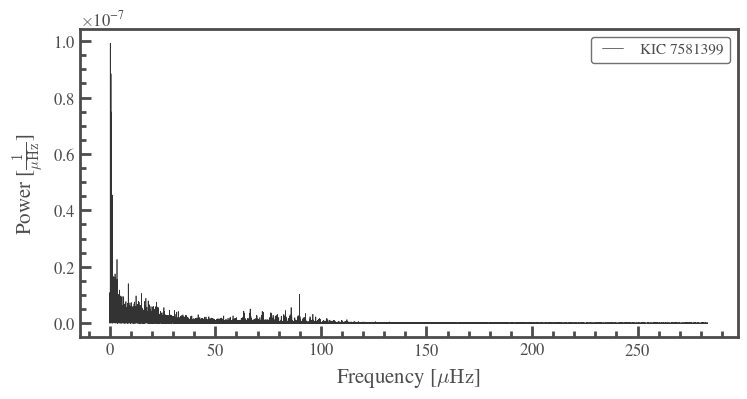

In [65]:
# lc_echelle = lk.search_lightcurve('KIC 5439339').download_all().stitch()
lc_echelle = lk.search_lightcurve('KIC 7581399').download_all().stitch()
lc_echelle = lc_echelle.remove_nans()
pg = lc_echelle.to_periodogram(normalization='psd')
pg.plot();

In [66]:
def calc_lomb_scargle(t,y):
   oversample = 10
   tmax = t.max()
   tmin = t.min()
   df = 1.0 / (tmax - tmin)
   fmin = df
   fmax = 600 # maximum frequency in cycles per day (c/d)
 
   freq = np.arange(fmin, fmax, df / oversample)
   model = LombScargle(t, y)
   sc = model.power(freq, method="fast", normalization="psd")
 
   fct = np.sqrt(4./len(t))
   amp = np.sqrt(sc) * fct
   return freq*11.574, amp*1E6 # return frequency in muHz and amplitude in ppm

In [67]:
freq,amp = calc_lomb_scargle(lc_echelle.time.value,lc_echelle.flux.value)
amp

array([2.55845404, 2.33669673, 2.17715099, ..., 1.17088678, 1.17054783,
       1.1481808 ])

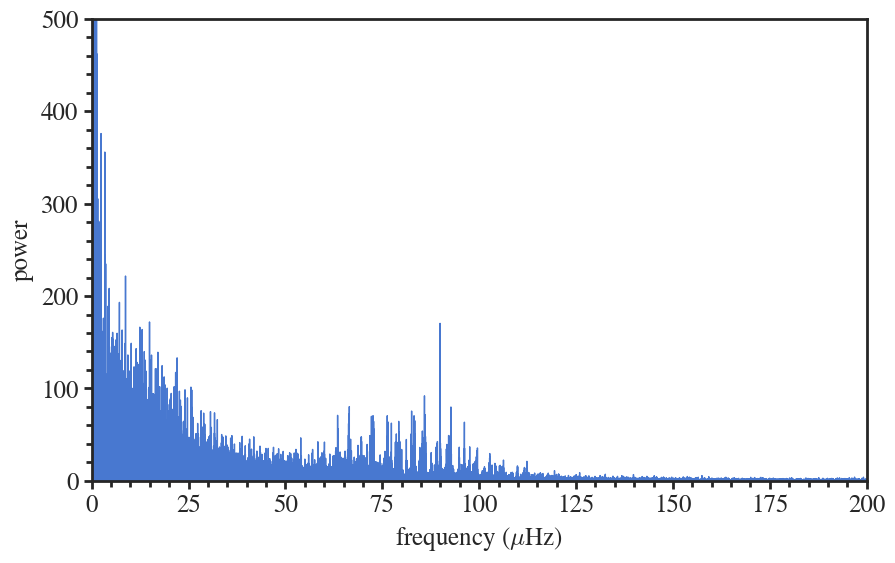

In [72]:
plt.figure(figsize=(10,6))
plt.plot(freq,amp**2,linewidth=1)
# plt.ylim(0,200)
# plt.xlim(60,120)
plt.ylim(0,500)
plt.xlim(0,200)
# plt.axvline(0.03,color='k')
plt.xlabel(r'frequency ($\mu$Hz)')
plt.ylabel('power')
plt.show()

<AxesSubplot:xlabel='Frequency mod 6.58', ylabel='Frequency'>

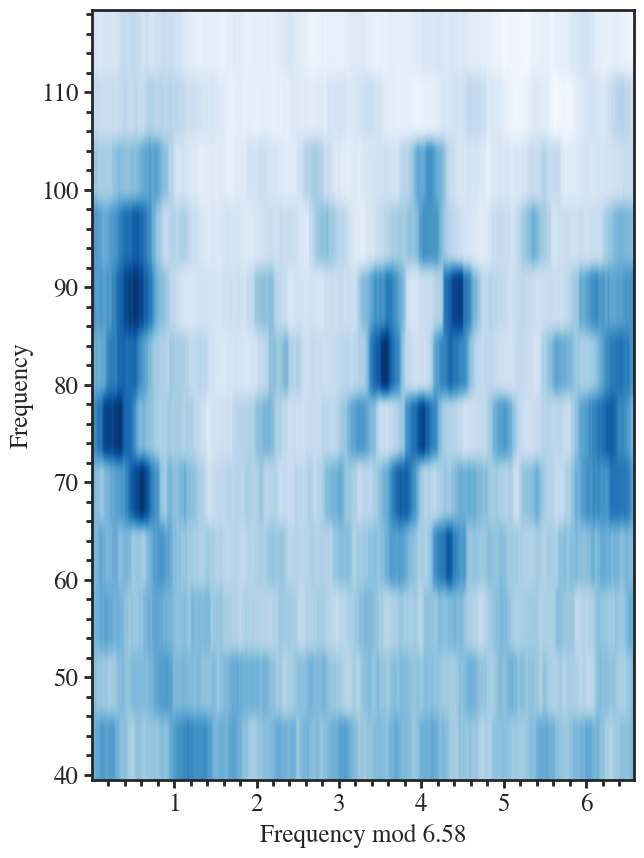

In [350]:
fig, ax = plt.subplots(figsize=[7,10])
echelle.plot_echelle(pg.frequency.value, pg.power.value, 6.58, scale='sqrt', smooth=True, ax=ax,
                    fmin=40,fmax=120,smooth_filter_width=30)

In [47]:
np.log10(9)

0.9542425094393249

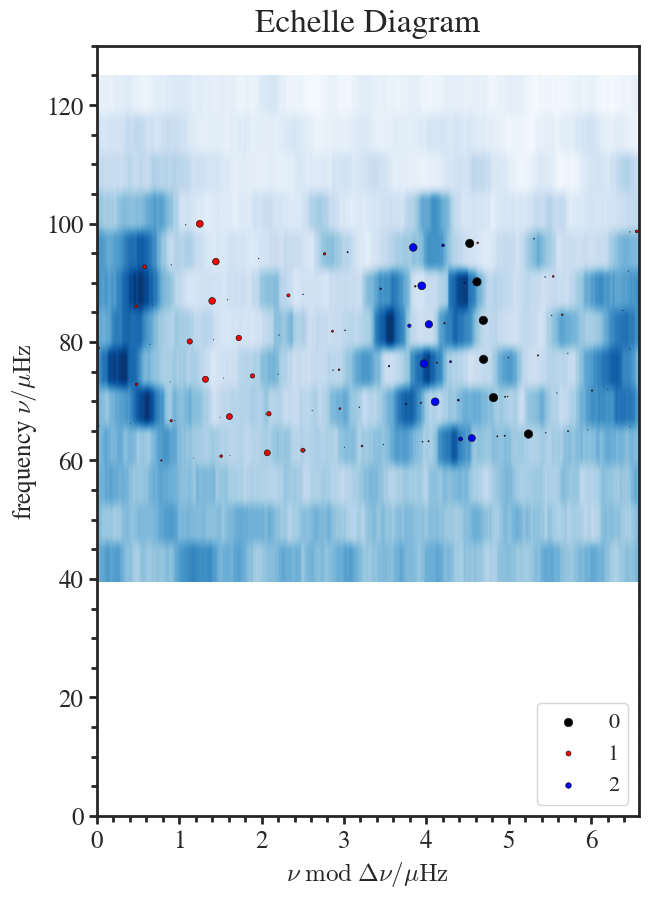

In [112]:
# fig, ax = plt.subplots(figsize=[7,10])
# echelle.plot_echelle(pg.frequency.value, pg.power.value, 4.10, scale='sqrt', smooth=True, ax=ax,
#                     fmin=20,fmax=70,smooth_filter_width=30)

plot_observed_echelle(50,freq,pg.frequency.value, pg.power.value, 6.58,
                      fmin=40,fmax=130,smooth_filter_width=30)

In [33]:
def period_echelle(profile_number,freq,Delta_P=0):
    hist = get_history(profile_number,DF,index)
    prof = profs[profile_number-1]
    freq = freq
    
    nu_max   = hist.nu_max.values[0]
    Delta_nu = hist.delta_nu.values[0]
    Delta_P_default = hist.delta_Pg.values[0] # seconds
    if Delta_P == 0:
        Delta_P = Delta_P_default
#     Delta_P = 300
#     print(Delta_P)
    
    freq = freq[freq['Re(freq)'] < 5/3*nu_max]
    dipole = freq[np.logical_and(freq.l == 1, freq.n_p > 2)]
    period = 1/(dipole['Re(freq)']*1e-6)
#     print(period)
    
#     plt.scatter(dipole['Re(freq)'] % Delta_P, dipole['Re(freq)'], 
#                 marker='.', facecolor='k', edgecolor='k',linewidth=0.5)
    plt.figure(figsize=(6,10))
    plt.scatter(period % Delta_P, dipole['Re(freq)'], 
                marker='.', facecolor='k', edgecolor='k',linewidth=0.5)
    plt.plot(period % Delta_P, dipole['Re(freq)'], linewidth=0.5)
    
#     colors = ('black', 'red', 'blue', 'purple')
#     for ell in np.unique(freq.l.values):
#         nus = freq[freq.l == ell]
#         plt.scatter(nus['Re(freq)'] % Dnu,
#                  nus['Re(freq)'], marker='.', 
#                 facecolor=colors[ell], edgecolor='k',linewidth=0.5,
#                     alpha=1, s=nus['E_p']*150, 
#                  label=str(ell))
#         plt.plot(nus['Re(freq)'] % Dnu,
#                  nus['Re(freq)'], '.', 
#                  mfc=colors[ell], mec='white', alpha=0.85,
#                  mew=1, markersize=nus['E_p'], 
#                  label=str(ell))
    
#     plt.legend(loc='lower right')
    
    plt.axvline(Delta_P, ls='--', c='darkgray', zorder=-99)
    plt.axhline(nu_max, ls='--', c='darkgray', zorder=-99)
    
#     plt.ylim([0, nu_max*5/3*1.2])
    plt.xlim([0, Delta_P])
    
    plt.ylabel(r'frequency $\nu/\mu\rm{Hz}$')
    plt.xlabel(r'P $\rm{mod}\; \Delta P/s$ '+str(Delta_P))
    plt.title('Period Echelle Diagram', size=24)
    plt.show()

In [ ]:
# def stretched_period_echelle(profile_number,freq,Delta_P=0):
#     hist = get_history(profile_number,DF,index)
#     prof = profs[profile_number-1]
#     freq = freq
    
#     nu_max   = hist.nu_max.values[0]
#     Delta_nu = hist.delta_nu.values[0]
#     Delta_P_default = hist.delta_Pg.values[0] # seconds
#     if Delta_P == 0:
#         Delta_P = Delta_P_default
# #     Delta_P = 300
# #     print(Delta_P)
    
#     freq = freq[freq['Re(freq)'] < 5/3*nu_max]
#     dipole = freq[np.logical_and(freq.l == 1, freq.n_p > 2)]
#     period = 1/(dipole['Re(freq)']*1e-6)
# #     print(period)
    
# #     plt.scatter(dipole['Re(freq)'] % Delta_P, dipole['Re(freq)'], 
# #                 marker='.', facecolor='k', edgecolor='k',linewidth=0.5)
#     plt.figure(figsize=(6,10))
#     plt.scatter(period % Delta_P, dipole['Re(freq)'], 
#                 marker='.', facecolor='k', edgecolor='k',linewidth=0.5)
#     plt.plot(period % Delta_P, dipole['Re(freq)'], linewidth=0.5)
    
# #     colors = ('black', 'red', 'blue', 'purple')
# #     for ell in np.unique(freq.l.values):
# #         nus = freq[freq.l == ell]
# #         plt.scatter(nus['Re(freq)'] % Dnu,
# #                  nus['Re(freq)'], marker='.', 
# #                 facecolor=colors[ell], edgecolor='k',linewidth=0.5,
# #                     alpha=1, s=nus['E_p']*150, 
# #                  label=str(ell))
# #         plt.plot(nus['Re(freq)'] % Dnu,
# #                  nus['Re(freq)'], '.', 
# #                  mfc=colors[ell], mec='white', alpha=0.85,
# #                  mew=1, markersize=nus['E_p'], 
# #                  label=str(ell))
    
# #     plt.legend(loc='lower right')
    
#     plt.axvline(Delta_P, ls='--', c='darkgray', zorder=-99)
#     plt.axhline(nu_max, ls='--', c='darkgray', zorder=-99)
    
# #     plt.ylim([0, nu_max*5/3*1.2])
#     plt.xlim([0, Delta_P])
    
#     plt.ylabel(r'frequency $\nu/\mu\rm{Hz}$')
#     plt.xlabel(r'P $\rm{mod}\; \Delta P/s$ '+str(Delta_P))
#     plt.title('Stretched Period Echelle Diagram', size=24)
#     plt.show()

In [34]:
interact(period_echelle,profile_number=fixed(50),freq=fixed(freq),
         Delta_P=FloatSlider(min=235,max=245,step=0.5))

interactive(children=(FloatSlider(value=235.0, description='Delta_P', max=245.0, min=235.0, step=0.5), Output(…

<function __main__.period_echelle(profile_number, freq, Delta_P=0)>

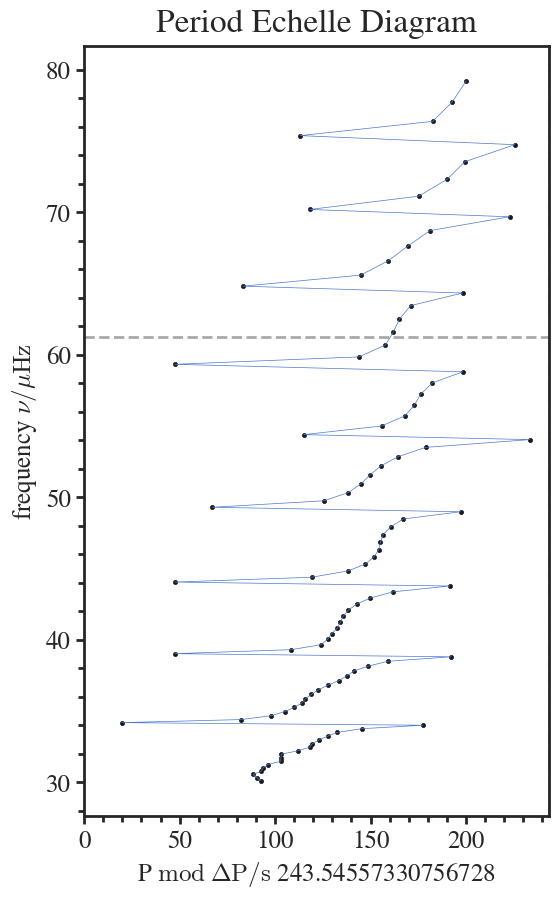

In [35]:
period_echelle(50,freq)

In [63]:
def gyre_analysis(profile_number,logs_dir):
    plot_propagation(profile_number)
    freq = get_frequencies(profile_number,logs_dir)
    plot_echelle(profile_number,freq)

For the Eigenfunctions:

go back into the `gyre.in` file and modify the `ad_output` block to the following in order to get eigenfunctions:

```
&ad_output
    summary_file = 'profile1-freqs.dat'
    summary_file_format = 'TXT'
    summary_item_list = 'l,n_pg,n_p,n_g,freq,E_norm' 
    freq_units = 'UHZ' 
    detail_file_format = 'TXT'
    detail_template = 'profile1-freqs/%L_%N'
    detail_item_list = 'M_star,R_star,l,n_pg,n_p,n_g,freq,E,E_p,E_g,E_norm,M_r,x,xi_r,xi_h'
/
```

make a directory `profilex-freqs` to put the results in, and run GYRE:

```
    mkdir profile1-freqs
    $GYRE_DIR/bin/gyre gyre.in
```

Alternatively to all of the above, just call the `../../src/gyre6freqs.sh` script with the `-e` flag (for eigenfunctions):

    ../../src/gyre6freqs.sh -i profile1.data.FGONG -f -e

In [72]:
def get_eigenfunctions(profile_number,logs_dir):
    eig_dir = os.path.join(logs_dir, 'profile' + str(profile_number) + '-freqs')
    eigs = {}
    for fname in os.listdir(eig_dir):
        if fname[:2] != '00':
            continue
        eig_i = pd.read_table(os.path.join(eig_dir, fname), sep='\s+', skiprows=5)
        sph_deg, rad_ord = fname.split('_')
        eigs[(int(sph_deg), 'x')] = eig_i['x']
        eigs[(int(sph_deg), int(rad_ord))] = eig_i[['Re(xi_r)', 'Re(xi_h)']]
    return eigs

In [75]:
eigs = get_eigenfunctions(26,logs_dir)
eigs[(0,4)]

,Re(xi_r),Re(xi_h)
0,0.000000e+00,0.0
1,-1.815075e-08,0.0
2,-2.286901e-08,0.0
3,-2.881396e-08,0.0
4,-3.630480e-08,0.0
...,...,...
1635,1.246651e+02,0.0
1636,1.246656e+02,0.0
1637,1.246650e+02,0.0
1638,1.246631e+02,0.0


In [85]:
eigs.keys()

dict_keys([(2, 'x'), (2, -119), (2, -314), (2, -126), (2, -121), (2, -313), (1, 'x'), (1, -33), (2, -128), (2, -117), (2, -325), (1, -34), (2, -322), (2, -110), (2, -144), (1, -94), (1, -60), (1, -58), (2, -143), (1, -67), (2, -188), (1, -93), (2, -181), (2, -175), (1, -51), (2, -172), (2, -340), (1, -69), (2, -186), (1, -56), (1, -35), (2, -111), (2, -323), (2, -129), (2, -324), (2, -116), (2, -312), (2, -120), (2, -118), (2, -127), (2, -187), (1, -68), (2, -341), (2, -173), (1, -57), (2, -174), (2, -180), (1, -50), (2, -142), (1, -59), (1, -92), (2, -189), (1, -66), (2, -145), (1, -61), (1, -95), (1, -113), (2, -205), (1, -114), (2, -202), (1, -122), (2, -234), (1, -125), (2, -233), (2, -267), (2, -293), (2, -258), (1, -185), (1, -171), (2, -294), (1, -149), (2, -260), (2, -99), (1, -176), (1, -182), (2, -90), (0, 'x'), (0, 13), (2, -256), (1, -140), (2, -269), (0, 14), (2, -251), (2, -97), (1, -178), (1, -147), (1, -124), (2, -232), (1, -123), (2, -235), (1, -115), (2, -203), (1, -1

In [76]:
def plot_eigs(sph_deg, rad_ord):
    x   = eigs[(sph_deg, 'x')]
    eig = eigs[(sph_deg, rad_ord)]
    plt.plot(x, eig['Re(xi_r)'], label='radial',     lw=3, zorder=11)
    plt.plot(x, eig['Re(xi_h)'], label='horizontal', lw=3, zorder=10)
    
    plt.xlabel(r'fractional radius $r/R$')
    plt.ylabel(r'eigenfunction $\xi$')
    plt.axhline(0, ls='--', c='k', alpha=1, zorder=-10)
    
    plt.xlim([0,1])
    plt.ylim([-20, 20])
    
    plt.suptitle(r'$\ell = {%d},\; n = {%d}$' % (sph_deg, rad_ord))
    plt.legend(loc='upper left')

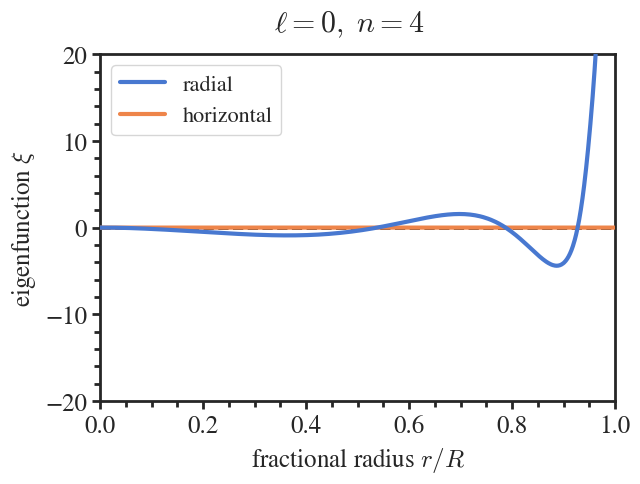

In [94]:
plot_eigs(0,4)

In [138]:
def plot_eigen_prop(profile_number,sph_deg, rad_ord):
    hist = get_history(profile_number,DF,index)
    prof = profs[profile_number-1]
    
    r_coord = 10**prof.logR / np.max(10**prof.logR)
    brunt = prof.brunt_N.values/(2*np.pi)*1e6
    lamb  = prof.lamb_S.values*1e6
    plt.plot(r_coord, brunt, lw=3, label='Brunt')
#     plt.plot(r_coord, lamb, lw=3, label='Lamb')
    
    gmodes = np.minimum(brunt, lamb)
    pmodes = np.maximum(brunt, lamb)
#     plt.fill_between(r_coord, 
#                      np.zeros(len(gmodes)), 
#                      gmodes, 
#                      color='blue', alpha=0.1, zorder=-99)
#     plt.fill_between(r_coord, 
#                      1e99*np.ones(len(pmodes)), 
#                      pmodes, 
#                      color='orange', alpha=0.1, zorder=-99)
    
    nu_max   = hist.nu_max.values[0]
    Delta_nu = hist.delta_nu.values[0]
#     plt.axhline(nu_max, ls='--', c='k', label=r'$\nu_\max$', zorder=100)
#     plt.fill_between([0, 1], 
#                      nu_max-5*Delta_nu, 
#                      nu_max+5*Delta_nu, 
#                      color='#aaaaaa', zorder=-98)
    
    
    r_coord_eig   = eigs[(sph_deg, 'x')]
    eig = eigs[(sph_deg, rad_ord)]
    plt.plot(r_coord_eig, eig['Re(xi_r)']*1e4, label='radial',     lw=1, zorder=11)
    plt.plot(r_coord_eig, eig['Re(xi_h)']*1e4, label='horizontal', lw=1, zorder=10)
    
    plt.xlabel(r'fractional radius $r/R$')
#     plt.ylabel(r'eigenfunction $\xi$')
    plt.axhline(0, ls='--', c='k', alpha=1, zorder=-10)
    
    
#     plt.semilogy()
#     plt.yscale('log')
#     plt.ylim([0, 1e7]) #500*nu_max])
    plt.ylim([-4e4,4e4])
#     plt.xlim([0,1])
    plt.xlim([0,0.015])
    
    plt.suptitle(r'$\ell = {%d},\; n = {%d}$' % (sph_deg, rad_ord))
    plt.legend(loc='best')
    plt.show()

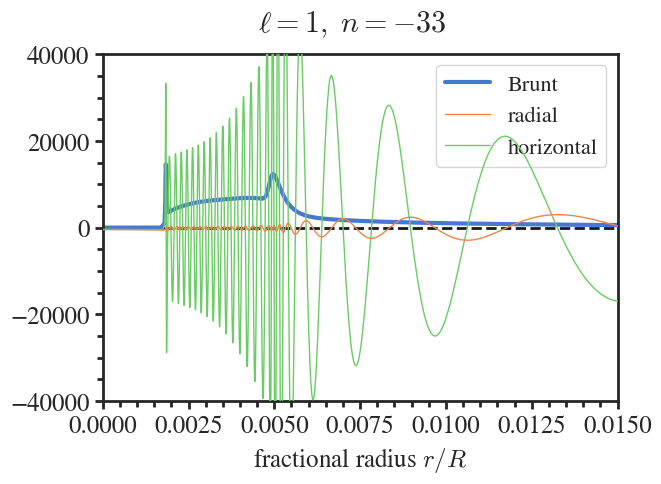

In [144]:
plot_eigen_prop(26,1,-33)

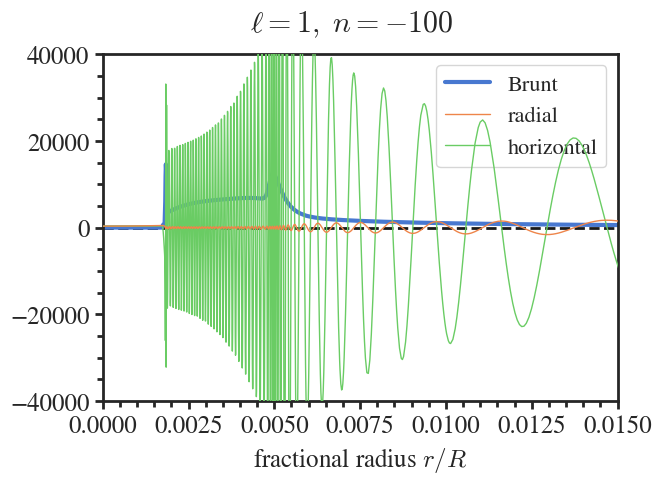

In [143]:
plot_eigen_prop(26,1,-100)

In [141]:
freq[freq.l==1]['n_pg']

13    -195
14    -194
15    -193
16    -192
17    -191
      ... 
171    -37
172    -36
173    -35
174    -34
175    -33
Name: n_pg, Length: 163, dtype: int64